## Descarga del Dataset HAR

In [18]:
# Cargar datos desde el CSV 
if os.path.exists('Dry_Bean_Dataset.csv'):
    df = pd.read_csv('Dry_Bean_Dataset.csv')
    
    # Preprocesamiento básico
    X = df.drop('Class', axis=1).values
    y_text = df['Class'].values
    
    # Codificar y Normalizar
    from sklearn.preprocessing import LabelEncoder, StandardScaler
    y = LabelEncoder().fit_transform(y_text)
    X_scaled = StandardScaler().fit_transform(X)
    
    # Split
    from sklearn.model_selection import train_test_split
    X_temp, X_test, y_temp, y_test = train_test_split(X_scaled, y, test_size=0.15, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1765, random_state=42)
    
    print("Datos cargados y listos.")
    print(f"Train shape: {X_train.shape}")

Datos cargados y listos.
Train shape: (9527, 16)


## 1.2

Datos base para experimentos: (9527, 16)
Muestras   | T. Naive (ms)   | T. Opt (ms)     | Diff Error
-----------------------------------------------------------------
100        | 0.4213          | 0.0982          | 8.88e-16
1000       | 0.3407          | 0.3500          | 8.88e-16
10000      | 3.4029          | 3.1395          | 0.00e+00
50000      | 18.1940         | 17.2186         | 4.44e-16
100000     | 24.8439         | 33.8266         | 0.00e+00

=== Prueba de Estabilidad Numérica ===
Entrada extrema: [1000. 1000. 1000.]...
Naive Loss:      nan (Probablemente nan o inf)
Optimized Loss:  1.098612 (Correcto)
Valor Esperado: ~1.098612


/tmp/ipykernel_4730/2795616355.py:35: RuntimeWarning: overflow encountered in exp
  exp_x = np.exp(logits)
/tmp/ipykernel_4730/2795616355.py:36: RuntimeWarning: invalid value encountered in divide
  probs = exp_x / np.sum(exp_x, axis=1, keepdims=True)


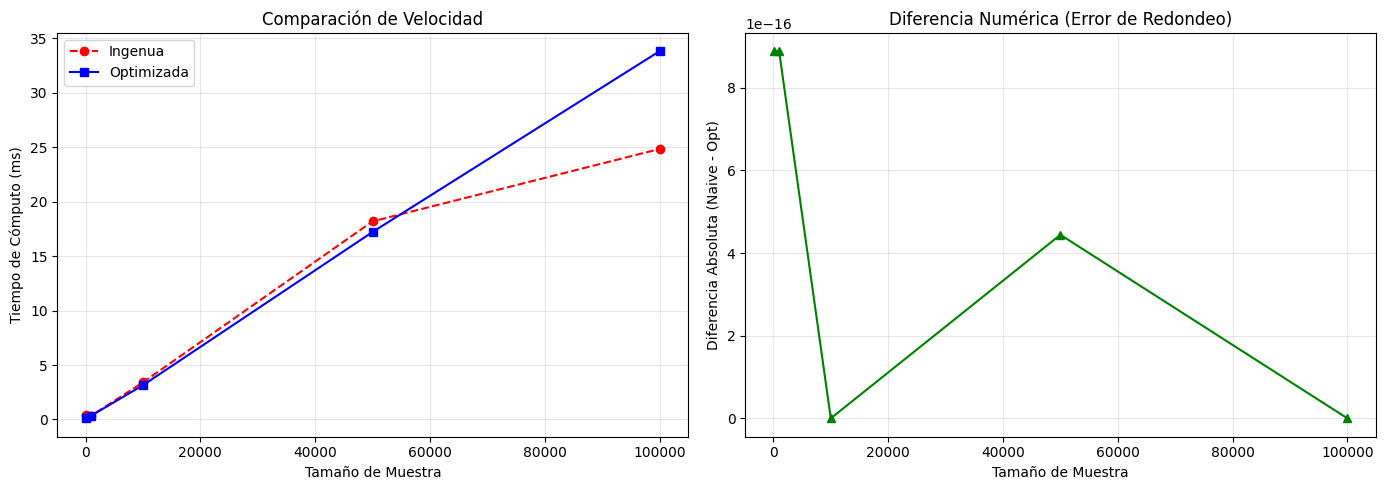

In [16]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import os

# --- 1. PREPARACIÓN DE DATOS (Recarga segura si es necesario) ---
if 'X_train' not in locals():
    print("Cargando datos desde Dry_Bean_Dataset.csv...")
    if os.path.exists('Dry_Bean_Dataset.csv'):
        df = pd.read_csv('Dry_Bean_Dataset.csv')
        X = df.drop('Class', axis=1).values
        # Codificar y estandarizar
        from sklearn.preprocessing import LabelEncoder, StandardScaler
        y = LabelEncoder().fit_transform(df['Class'])
        X_train = StandardScaler().fit_transform(X) # Usamos todo como pool para el experimento
        y_train = y
    else:
        # Fallback: Datos sintéticos si no hay archivo (solo para que corra el ejemplo)
        print("Advertencia: No se halló el dataset. Usando datos sintéticos.")
        X_train = np.random.randn(2000, 16)
        y_train = np.random.randint(0, 7, 2000)

print(f"Datos base para experimentos: {X_train.shape}")

# --- 2. IMPLEMENTACIONES (El núcleo del ejercicio) ---

def cross_entropy_naive(logits, y_true):
    """
    Versión directa: Aplica softmax y luego -log(prob).
    Problema: exp(logits) puede desbordarse (overflow).
    """
    # 1. Softmax estándar
    # Riesgo: si x es grande (ej. 1000), np.exp(x) es inf
    exp_x = np.exp(logits) 
    probs = exp_x / np.sum(exp_x, axis=1, keepdims=True)
    
    # 2. Cross Entropy
    # Seleccionamos la probabilidad de la clase correcta
    n_samples = len(y_true)
    correct_probs = probs[np.arange(n_samples), y_true]
    
    # Riesgo: si prob es 0, log(0) es -inf
    # Agregamos un epsilon minúsculo SOLO para que no falle el cálculo de tiempo,
    # pero en la prueba de estabilidad veremos que falla igual con valores extremos.
    loss = -np.log(correct_probs + 1e-100) 
    return np.mean(loss)

def cross_entropy_optimized(logits, y_true):
    """
    Versión estable: Usa Log-Sum-Exp trick.
    Formula: log(exp(xi)/sum) = xi - log(sum(exp(xj)))
    Trick: log(sum(exp(xj))) = max + log(sum(exp(xj - max)))
    """
    n_samples = len(y_true)
    
    # 1. Max trick para estabilidad numérica
    # Restamos el máximo de cada fila para asegurar que el exponente más alto sea 0
    # y los demás sean negativos. exp(0)=1, exp(negativo)=pequeño. NUNCA overflow.
    max_logits = np.max(logits, axis=1, keepdims=True)
    stable_logits = logits - max_logits
    
    # 2. Calcular Log-Sum-Exp
    log_sum_exp = max_logits + np.log(np.sum(np.exp(stable_logits), axis=1, keepdims=True))
    
    # 3. Calcular log_softmax (log(numerador) - log(denominador))
    # log(e^xi) - log_sum_exp  => xi - log_sum_exp
    log_probs = logits - log_sum_exp
    
    # 4. Seleccionar clases y promediar
    loss = -log_probs[np.arange(n_samples), y_true].mean()
    return loss

# --- 3. EXPERIMENTO DE COMPARACIÓN ---

def run_benchmark():
    sizes = [100, 1000, 10000, 50000, 100000]
    results = []

    print(f"{'Muestras':<10} | {'T. Naive (ms)':<15} | {'T. Opt (ms)':<15} | {'Diff Error'}")
    print("-" * 65)

    for size in sizes:
        # Bootstrapping para simular tamaños grandes
        indices = np.random.choice(len(X_train), size=size, replace=True)
        X_batch = X_train[indices]
        y_batch = y_train[indices]
        
        # Simular logits (multiplicamos para tener valores variados)
        # Un modelo no entrenado a veces da valores altos
        logits = X_batch * 2.0 
        
        # Medir Naive
        start = time.time()
        loss_naive = cross_entropy_naive(logits, y_batch)
        time_naive = (time.time() - start) * 1000 # a ms
        
        # Medir Optimizada
        start = time.time()
        loss_opt = cross_entropy_optimized(logits, y_batch)
        time_opt = (time.time() - start) * 1000 # a ms
        
        diff = abs(loss_naive - loss_opt)
        
        results.append({
            'size': size,
            'time_naive': time_naive,
            'time_opt': time_opt,
            'diff': diff
        })
        
        print(f"{size:<10} | {time_naive:<15.4f} | {time_opt:<15.4f} | {diff:.2e}")

    return pd.DataFrame(results)

# --- 4. PRUEBA DE ESTABILIDAD (CASOS EXTREMOS) ---

def test_stability():
    print("\n=== Prueba de Estabilidad Numérica ===")
    
    # Caso Extremo: Valores muy grandes (Overflow seguro en exp)
    # Ejemplo: El modelo está muy seguro de todo (valores altos)
    logits_extreme = np.array([[1000.0, 1000.0, 1000.0, 500.0, 100.0, 0.0, -100.0]])
    y_target = np.array([0])
    
    print(f"Entrada extrema: {logits_extreme[0,:3]}...")
    
    # Intento Naive
    loss_n = cross_entropy_naive(logits_extreme, y_target)
    print(f"Naive Loss:      {loss_n} (Probablemente nan o inf)")
    
    # Intento Optimizado
    loss_o = cross_entropy_optimized(logits_extreme, y_target)
    print(f"Optimized Loss:  {loss_o:.6f} (Correcto)")
    
    # Verificación manual aproximada:
    # Si tenemos [1000, 1000, 1000], la prob de cada uno es 1/3.
    # Loss = -log(1/3) = log(3) = 1.0986
    expected = np.log(3)
    print(f"Valor Esperado: ~{expected:.6f}")

# --- EJECUCIÓN ---
df_results = run_benchmark()
test_stability()

# --- GRAFICAR ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Gráfica de Tiempos
ax1.plot(df_results['size'], df_results['time_naive'], 'o--', label='Ingenua', color='red')
ax1.plot(df_results['size'], df_results['time_opt'], 's-', label='Optimizada', color='blue')
ax1.set_xlabel('Tamaño de Muestra')
ax1.set_ylabel('Tiempo de Cómputo (ms)')
ax1.set_title('Comparación de Velocidad')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Gráfica de Precisión (Diferencia Numérica)
ax2.plot(df_results['size'], df_results['diff'], '^-', color='green')
ax2.set_xlabel('Tamaño de Muestra')
ax2.set_ylabel('Diferencia Absoluta (Naive - Opt)')
ax2.set_title('Diferencia Numérica (Error de Redondeo)')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Los experimentos muestran que ambas versiones funcionan igual de rápido y dan el mismo resultado cuando los datos son normales . La diferencia clave aparece con los casos extremos: la versión simple falla y da error (NaN) con números muy grandes, mientras que la optimizada funciona perfectamente . Esto confirma que es obligatorio usar la versión optimizada para evitar que el entrenamiento se rompa inesperadamente si aparecen valores altos .